In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import nltk                            # Cleaning the data
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional
from keras.utils import to_categorical
from tensorflow.python.client import device_lib 
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
print(device_lib.list_local_devices()) 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4750119656406060866
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15053656813958955999
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/syedhaider/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Usefull Functions

In [5]:
# get train_test split of each target df

def get_traintestsplit(df):
    train_X = df['Tweet']
    stance =  df['Stance']

    return train_test_split( train_X, stance , test_size = 0.2, random_state = 42)

In [6]:
# function to generate X and Y of test set

def generate_XY(df):
    X = df.iloc[:,0]
    Y = df.iloc[:,2]
    return X,Y

In [7]:
# max length of the tweet to fix our padding

def get_maxlength_tweet(df):
    tweet_len=[]
    for text in df['Tweet']:
        word=word_tokenize(text)
        l=len(word)
        tweet_len.append(l)

    return np.max(tweet_len)

In [36]:
# Function to deal with embedding file

def get_coef(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_emb_matrix(EMB_FILE, max_feature,emb_dimension, tokenizer):
    # word vectors
    emb_index = dict(get_coef(*x.rstrip().rsplit(' ')) for x in open(EMB_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(emb_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_feature, len(word_index) + 1)
    all_emb = np.stack(emb_index.values()) #for random init
    emb_matrix = np.random.normal(all_emb.mean(), all_emb.std(), (num_words, emb_dimension))
    
    for word, i in word_index.items():
        if i >= max_feature:
            continue
        emb_vector = emb_index.get(word)
        if emb_vector is not None:
            emb_matrix[i] = emb_vector
    max_feature = emb_matrix.shape[0]
    return emb_matrix

In [9]:
# Tokenize test data

def tokenize_testdata(testdf, max_feature, tokenizer):
    testdf = tokenizer.texts_to_sequences(testdf)

    return testdf

In [10]:
# Tokenize train data

def tokenize_traindata(X_train, X_val, max_feature):
    tokenizer = Tokenizer(num_words=max_feature)
    tokenizer.fit_on_texts(list(X_train))
    X_train = tokenizer.texts_to_sequences(X_train)
    X_val = tokenizer.texts_to_sequences(X_val)
    return X_train, X_val,tokenizer

In [11]:
# Padding our input data to make a vector of consistent size

def padding_traindata(X_train, X_val, max_word):
    X_train = sequence.pad_sequences(X_train, maxlen=max_word)
    X_val = sequence.pad_sequences(X_val, maxlen=max_word)
    return X_train, X_val

In [12]:
# Padding our test data to make a vector of consistent size

def padding_testdata(testdf, max_word):
    testdf = sequence.pad_sequences(testdf, maxlen=max_word)
    
    return testdf

In [13]:
# Label encoding (Y) train Target variable 

def label_encoding_train(Y_train, Y_val): 
    le = preprocessing.LabelEncoder()
    le.fit(Y_train)
    Y_train = le.transform(Y_train)
    Y_val = le.transform(Y_val)

    Y_train = to_categorical(Y_train, dtype ="uint8") 
    Y_val = to_categorical(Y_val, dtype ="uint8") 
    return Y_train, Y_val, le

In [14]:
# Label encoding (Y) test Target variable 

def label_encoding_test(Y_test, le): 
    Y_test = le.transform(Y_test) 
    
    return Y_test

### Data Handling

In [15]:
trainData = pd.read_pickle('../Pickle files/train_data.pkl')

In [16]:
testData = pd.read_pickle('../Pickle files/test_data.pkl')

In [17]:
print(trainData.shape)
print(testData.shape)

(2914, 3)
(1956, 3)


In [18]:
trainData.Target.value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [19]:
testData.Target.value_counts()

Donald Trump                        707
Hillary Clinton                     295
Feminist Movement                   285
Legalization of Abortion            280
Atheism                             220
Climate Change is a Real Concern    169
Name: Target, dtype: int64

In [20]:
# splitting data into multiple dataframes based on target values (train data)

hc_traindf =trainData[trainData['Target'] == 'Hillary Clinton']
fm_traindf =trainData[trainData['Target'] == 'Feminist Movement']
la_traindf =trainData[trainData['Target'] == 'Legalization of Abortion']
at_traindf =trainData[trainData['Target'] == 'Atheism']
cc_traindf =trainData[trainData['Target'] == 'Climate Change is a Real Concern']

In [21]:
# splitting data into multiple dataframes based on target values (test data)

hc_testdf =testData[testData['Target'] == 'Hillary Clinton']
fm_testdf =testData[testData['Target'] == 'Feminist Movement']
la_testdf =testData[testData['Target'] == 'Legalization of Abortion']
at_testdf =testData[testData['Target'] == 'Atheism']
cc_testdf =testData[testData['Target'] == 'Climate Change is a Real Concern']

In [22]:
# getting train test split values for each target df (train)

X_train1, X_val1, Y_train1, Y_val1 = get_traintestsplit(hc_traindf)
X_train2, X_val2, Y_train2, Y_val2 = get_traintestsplit(fm_traindf)
X_train3, X_val3, Y_train3, Y_val3 = get_traintestsplit(la_traindf)
X_train4, X_val4, Y_train4, Y_val4 = get_traintestsplit(at_traindf)
X_train5, X_val5, Y_train5, Y_val5 = get_traintestsplit(cc_traindf)

In [23]:
# generating X and Y of test set

X_test1, Y_test1 = generate_XY(hc_testdf)
X_test2, Y_test2 = generate_XY(fm_testdf)
X_test3, Y_test3 = generate_XY(la_testdf)
X_test4, Y_test4 = generate_XY(at_testdf)
X_test5, Y_test5 = generate_XY(cc_testdf)

In [26]:
# # max length of the review

# max_tweet_len1 = get_maxlength_tweet(hc_df)
# max_tweet_len2 = get_maxlength_tweet(fm_df)
# max_tweet_len3 = get_maxlength_tweet(la_df)
# max_tweet_len4 = get_maxlength_tweet(at_df)
# max_tweet_len5 = get_maxlength_tweet(cc_df)

In [27]:
# List of max features - Max words
# [HC : 3313, LA : 3041, at : 2580, CC : 2327, FM: 3397]

In [28]:
# get tokenized X_train and Y_train

X_train1, X_val1, tok1 = tokenize_traindata(X_train1, X_val1, 3313)
X_train2, X_val2, tok2 = tokenize_traindata(X_train2, X_val2, 3397)
X_train3, X_val3, tok3 = tokenize_traindata(X_train3, X_val3, 3041)
X_train4, X_val4, tok4 = tokenize_traindata(X_train4, X_val4, 2580)
X_train5, X_val5, tok5 = tokenize_traindata(X_train5, X_val5, 2327)

In [29]:
# get tokenized X_test and Y_test

X_test1 = tokenize_testdata(X_test1, 3313, tok1)
X_test2 = tokenize_testdata(X_test2, 3397, tok2)
X_test3 = tokenize_testdata(X_test3, 3041, tok3)
X_test4 = tokenize_testdata(X_test4, 2580, tok4)
X_test5 = tokenize_testdata(X_test5, 2327, tok5)

In [30]:
# padding our dataframes (train)

X_train1, X_val1 = padding_traindata(X_train1, X_val1, 300)
X_train2, X_val2 = padding_traindata(X_train2, X_val2, 300)
X_train3, X_val3 = padding_traindata(X_train3, X_val3, 300)
X_train4, X_val4 = padding_traindata(X_train4, X_val4, 300)
X_train5, X_val5 = padding_traindata(X_train5, X_val5, 300)

In [31]:
# padding our dataframes (test)

X_test1 = padding_testdata(X_test1, 300)
X_test2 = padding_testdata(X_test2, 300)
X_test3 = padding_testdata(X_test3, 300)
X_test4 = padding_testdata(X_test4, 300)
X_test5 = padding_testdata(X_test5, 300)

In [32]:
# Label encoding our Y (Target) variable (train)

Y_train1, Y_val1, le1 = label_encoding_train(Y_train1, Y_val1)
Y_train2, Y_val2, le2 = label_encoding_train(Y_train2, Y_val2)
Y_train3, Y_val3, le3 = label_encoding_train(Y_train3, Y_val3)
Y_train4, Y_val4, le4 = label_encoding_train(Y_train4, Y_val4)
Y_train5, Y_val5, le5 = label_encoding_train(Y_train5, Y_val5)

In [33]:
# padding our dataframes (test)

Y_test1 = label_encoding_test(Y_test1, le1)
Y_test2 = label_encoding_test(Y_test2, le2)
Y_test3 = label_encoding_test(Y_test3, le3)
Y_test4 = label_encoding_test(Y_test4, le4)
Y_test5 = label_encoding_test(Y_test5, le5)

In [34]:
le5.classes_

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [53]:
# loading our embedding file and storing words in matrix

EMB_FILE = '../Embeddings/glove.6B.300d.txt'
emb_dimension = 300 #word vector dim
emb_matrix1 = get_emb_matrix(EMB_FILE, 3313, emb_dimension, tok1)
emb_matrix2 = get_emb_matrix(EMB_FILE, 3397, emb_dimension, tok2)
emb_matrix3 = get_emb_matrix(EMB_FILE, 3041, emb_dimension, tok3)
emb_matrix4 = get_emb_matrix(EMB_FILE, 2580, emb_dimension, tok4)
emb_matrix5 = get_emb_matrix(EMB_FILE, 2327, emb_dimension, tok5)

Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.


In [65]:
print(emb_matrix1.shape,emb_matrix2.shape,emb_matrix3.shape,emb_matrix4.shape,emb_matrix5.shape)

(2291, 300) (2323, 300) (2106, 300) (1827, 300) (1710, 300)


In [ ]:
max_feature

### Model Building

In [ ]:
# Lets start our model building with a Single Layer LSTM and then we can built on it

# The reason why we are starting with LSTM is because we know its a very usefull model in NLP since it stores 
# the conext which is very important in our case

In [109]:
class StanceClassifierLSTM:
    
    def __init__(self, max_feature, num_classes):
        self.model = Sequential()
        self.max_feature = max_feature
        print(self.max_feature)
        self.num_classes = num_classes
        self.y_pred = 0
        self.history = 0
        
    def built_model(self, layers, emb_dimension, input_length1, emb_matrix):
        self.model.add(Embedding(self.max_feature, emb_dimension, input_length=input_length1,weights=emb_matrix,trainable=True))
        self.model.add(SpatialDropout1D(0.25))
        # model.add(Bidirectional(LSTM(128,return_sequences=True)))
        self.model.add((LSTM(64,return_sequences=False)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(3, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    def get_modelsummary(self):
        self.model.summary()
        
    def fit_model(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        self.history =  self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs,
                             batch_size=batch_size, verbose=1)
        return self.history
    
    def predict_model(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred
    
    def evaluate_model(self, X_test, Y_test, le):
        Y_test = to_categorical(Y_test)
        print("result")
        print(self.model.evaluate(X_test,Y_test))       
        
    def display_confusionmatrix(self, Ytest):
        self.y_test_predicted  = []
        for i in self.y_pred:
            self.y_test_predicted.append(np.argmax(i))
        print(confusion_matrix(Ytest.tolist(), self.y_test_predicted, labels =[0,1,2]))    
        
    def plot_results(self):
        # summarize history for accuracy
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    

2291
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 300, 300)          687300    
_________________________________________________________________
spatial_dropout1d_32 (Spatia (None, 300, 300)          0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                42624     
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 99        
Total params: 730,023
Trainable params: 730,023
Non-trainable params: 0
__________________________________________

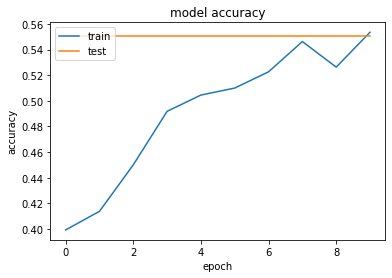

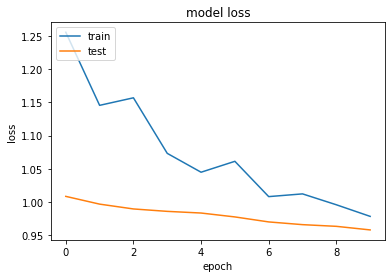

In [108]:
ST = StanceClassifierLSTM(emb_matrix1.shape[0], 3)
ST.built_model(1, emb_dimension, X_train1.shape[1], [emb_matrix1])
ST.get_modelsummary()
history = ST.fit_model(X_train1, Y_train1, X_val1, Y_val1, 10, 32)
pred = ST.predict_model(X_test1)
ST.evaluate_model(X_test1, Y_test1, le1)
ST.display_confusionmatrix(Y_test1)
ST.plot_results()

In [101]:
history.history

{'loss': [1.0246778726577759],
 'accuracy': [0.5372051000595093],
 'val_loss': [1.0005351305007935],
 'val_accuracy': [0.5507246255874634]}

In [73]:
ST1 = StanceClassifierLSTM(emb_matrix2.shape[0], 3)
ST1.built_model(1, emb_dimension, X_train2.shape[1], [emb_matrix2])
ST1.get_modelsummary()
ST1.fit_model(X_train2, Y_train2, X_val2, Y_val2, 15, 32)
pred = ST1.predict_model(X_test2)
ST1.display_results(Y_test2)

2323
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 300, 300)          696900    
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 300, 300)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 387       
Total params: 884,167
Trainable params: 884,167
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
17/17 [==============================] - 6s 324ms/step - loss: 1.0799 - accuracy: 0.4331 - val_lo

In [74]:
ST2 = StanceClassifierLSTM(emb_matrix3.shape[0], 3)
ST2.built_model(1, emb_dimension, X_train3.shape[1], [emb_matrix3])
ST2.get_modelsummary()
ST2.fit_model(X_train3, Y_train3, X_val3, Y_val3, 15, 33)
pred = ST2.predict_model(X_test3)
ST2.display_results(Y_test3)

2106
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 300, 300)          631800    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 300, 300)          0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
Total params: 819,067
Trainable params: 819,067
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
16/16 [==============================] - 6s 404ms/step - loss: 1.0790 - accuracy: 0.4713 - val_lo

In [75]:
ST3 = StanceClassifierLSTM(emb_matrix4.shape[0], 3)
ST3.built_model(1, emb_dimension, X_train4.shape[1], [emb_matrix4])
ST3.get_modelsummary()
ST3.fit_model(X_train4, Y_train4, X_val4, Y_val4, 15, 33)
pred = ST3.predict_model(X_test4)
ST3.display_results(Y_test4)

1827
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 300, 300)          548100    
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 300, 300)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
Total params: 735,367
Trainable params: 735,367
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
13/13 [==============================] - 4s 325ms/step - loss: 1.0271 - accuracy: 0.5683 - val_lo

In [76]:
ST4 = StanceClassifierLSTM(emb_matrix5.shape[0], 3)
ST4.built_model(1, emb_dimension, X_train5.shape[1], [emb_matrix5])
ST4.get_modelsummary()
ST4.fit_model(X_train5, Y_train5, X_val5, Y_val5, 15, 33)
pred = ST4.predict_model(X_test5)
ST4.display_results(Y_test5)

1710
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 300, 300)          513000    
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 300, 300)          0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 387       
Total params: 700,267
Trainable params: 700,267
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
10/10 [==============================] - 4s 401ms/step - loss: 0.9344 - accuracy: 0.4937 - val_lo